# qPCR analysis

## Немножко основ

Термины

* $e$ - эффективность амплификации данного гена в данных условиях: $1 < e < 2$
* $N_x$ - число молекул продукта после цикла $x$
* Ct - номер цикла, на котором интенсивность флуоресценции превышает порог (куча разных вариантов расчета).
* reference - ген сравнения (с константной экспрессией), target - ген интереса
* control - проба-контроль (клетки без воздействия), treatment - проба, которую надо сравнить с контролем (после воздействия)

$\begin{align}
N_{i+1} = N_i \cdot e \\
N_x = N_0 \cdot e^x
\end{align}$

(на самом деле $N_x = N_0 \cdot e^{x-1}$, если ДНК одноцепочечная в начале, т.е. кДНК, но далее это будет неважно)

$\begin{align}
&I_{fluorescence} = k \cdot N_x \\
&N \sim e^{-Ct}
\end{align}$

Если $e_{\text{target}}=e_{\text{reference}}=2$ (эффективность амплификации 100%, т.е. полное удвоение за цикл), то

$\begin{align}
&N \sim 2^{-Ct} \\
&R^{sample} = \frac{N^{sample}_{target}}{N^{sample}_{reference}} = \frac{2^{-Ct^{sample}_{target}}}{2^{-Ct^{sample}_{reference}}} = 2^{Ct^{sample}_{reference}-Ct^{sample}_{target}} = 2^{\Delta Ct^{sample}} \\
&R^{treatment/control} = \frac{2^{\Delta Ct^{treatment}}}{2^{\Delta Ct^{control}}} = 2^{\Delta Ct^{treatment}-\Delta Ct^{control}} = 2^{\Delta\Delta Ct}
\end{align}$

Если эффективности отличаются, формула сложнее

$\begin{align}
R^{treatment/control} = \frac{{e_{target}}^{-Ct^{treatment}_{target}}}{{e_{reference}}^{-Ct^{treatment}_{reference}}} \cdot \frac{{e_{reference}}^{-Ct^{control}_{reference}}}{{e_{target}}^{-Ct^{control}_{target}}}
\end{align}$

Как расчитать $e_{gene}$? Исходя из формулы $N_{i+1} = N_i \cdot e$. Однако на разных участках кривой это значение разное, нам нужен участок с геометрической прогрессией. Но как его найти? Есть много алгоритмов.

## Расчеты на R

In [230]:
library(qpcR)
library(tidyverse)

Как выглядят тестовые данные?

In [133]:
# data
reps[1:5,1:5]

Cycles,F1.1,F1.2,F1.3,F1.4
1,-0.059106239,-0.056939713,0.005921348,-0.022848656
2,-0.036877204,-0.035405393,0.014257227,-0.011515292
3,-0.015347616,-0.019087576,0.020401344,0.003447348
4,-0.000611298,-0.002992528,0.034001042,0.009564208
5,0.021857274,0.022171068,0.039705011,0.021352392


In [137]:
reps[,1:9] %>% str

'data.frame':	49 obs. of  9 variables:
 $ Cycles: num  1 2 3 4 5 6 7 8 9 10 ...
 $ F1.1  : num  -0.059106 -0.036877 -0.015348 -0.000611 0.021857 ...
 $ F1.2  : num  -0.05694 -0.03541 -0.01909 -0.00299 0.02217 ...
 $ F1.3  : num  0.00592 0.01426 0.0204 0.034 0.03971 ...
 $ F1.4  : num  -0.02285 -0.01152 0.00345 0.00956 0.02135 ...
 $ F2.1  : num  -0.0265 -0.01878 -0.00878 -0.00158 0.01404 ...
 $ F2.2  : num  -0.02837 -0.01717 -0.00796 -0.00335 0.01216 ...
 $ F2.3  : num  -0.0158 0.0145 0.0221 0.0234 0.0323 ...
 $ F2.4  : num  0.00246 0.0043 0.01271 0.02062 0.02297 ...


Фитируем модели с помощью 4-параметрических сигмоид (`l4`).

In [ ]:
options(repr.plot.width = 3,repr.plot.height = 2.5)
op <- par(oma = c(2,4,0,0) + 0.1,
          mar = c(0,0,1,1) + 0.1)

Calculating delta of first/second derivative maxima...
........
[1] "modlist" "pcrfit" 


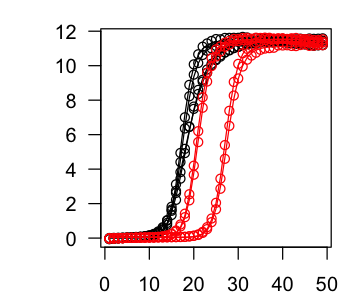

In [200]:
ml1 <- modlist(reps, 1, c(2:7, 14:15), model = l4, verbose=F)
plot(ml1, col = gl(3,4))

Теперь из кривых можно посчитать Ct и эффективности (дофига настроек, алгоритмов расчета).

In [225]:
ct = getPar(ml1, type = "curve", cp = "cpD2", eff='sliwin')
ct

.......
......
...........
..........
.......
........
........
.......



,F1.1,F1.2,F1.3,F1.4,F2.1,F2.2,F4.1,F4.2
ct,15.440000,15.330000,14.840000,15.340000,18.890000,18.710000,25.340000,25.120000
eff,1.739444,1.737737,1.614832,1.668115,1.763094,1.762981,1.742593,1.756755


Расчитать fold-difference (R) можно так (опять же, куча настроек) исходя из исходных кривых.

In [223]:
groups = c("r1s1", "r1s1", "r1c1", "r1c1", "g1s1", "g1s1", "g1c1", "g1c1")
dat <- pcrbatch(reps, fluo = c(2:7, 14:15), model = l4, verbose = F, plot=F)
ratiobatch(dat, groups, plot=F, verbose=F, which.cp = "cpD2", which.eff = 'sli')$resList

,Sim,Perm,Prop
Mean,90.67641,90.41843,90.65303
Std.dev.,19.54307,16.58180,19.08684
Median,88.78741,104.52708,NA
MAD,18.96402,6.52282,NA
Conf.lower,58.04798,72.36526,53.24351
Conf.upper,134.98803,108.59670,128.06255
perm > init,NA,0.00000,NA
perm == init,NA,0.51000,NA
perm < init,NA,0.49000,NA


Похоже на правду, если вручную прикинуть, считая, что эффективность 2.

In [181]:
2^(25.3-18.8)

[1] 90.50967

### Если есть только Ct???

С эффективностями результат конечно лучше...

In [226]:
print(groups)
ct_vector = as.numeric(ct[1,])
print(ct_vector)
eff_vector = as.numeric(ct[2,])
print(eff_vector)
ratioPar(group = groups, effVec = eff_vector, cpVec= ct_vector, plot=F)$resList

[1] "r1s1" "r1s1" "r1c1" "r1c1" "g1s1" "g1s1" "g1c1" "g1c1"
[1] 15.44 15.33 14.84 15.34 18.89 18.71 25.34 25.12
[1] 1.739444 1.737737 1.614832 1.668115 1.763094 1.762981 1.742593 1.756755

Checking if sample number and 'group' length are equal...
Checking that 'group' is of class <character>...
Checking for number of control samples, treatment samples, 
genes-of-interest and reference genes:
 Found 1 control sample(s)...
 Found 1 treatment sample(s)...
 Found 1 genes-of-interest in control sample(s)...
 Found 1 genes-of-interest in treatment sample(s)...
 Found 1 reference genes in control sample(s)...
 Found 1 reference genes in treatment sample(s)...
Calculating r1s1:r1c1:g1s1:g1c1 (1 of 1)...


,Sim,Perm,Prop
Mean,97.59576,92.69254,97.21504
Std.dev.,43.74558,29.59494,40.00655
Median,88.80740,64.54520,NA
MAD,37.19225,2.58008,NA
Conf.lower,37.64064,62.93548,18.80364
Conf.upper,206.88286,124.18806,175.62643
perm > init,NA,0.00000,NA
perm == init,NA,0.50250,NA
perm < init,NA,0.49750,NA


Но можно считать, что все эффективности равны 2, тогда результат немного отличается.

In [227]:
ratioPar(group = groups, effVec = rep(2, length(ct_vector)), cpVec= ct_vector, plot=F)$resList


Checking if sample number and 'group' length are equal...
Checking that 'group' is of class <character>...
Checking for number of control samples, treatment samples, 
genes-of-interest and reference genes:
 Found 1 control sample(s)...
 Found 1 treatment sample(s)...
 Found 1 genes-of-interest in control sample(s)...
 Found 1 genes-of-interest in treatment sample(s)...
 Found 1 reference genes in control sample(s)...
 Found 1 reference genes in treatment sample(s)...
Calculating r1s1:r1c1:g1s1:g1c1 (1 of 1)...


,Sim,Perm,Prop
Mean,110.23106,109.472067,110.14264
Std.dev.,32.27426,26.812584,30.98036
Median,105.93814,132.513910,NA
MAD,30.09002,9.767594,NA
Conf.lower,60.60519,80.748830,49.42224
Conf.upper,184.84425,138.607951,170.86304
perm > init,NA,0.000000,NA
perm == init,NA,0.520500,NA
perm < init,NA,0.479500,NA
